# Studio COVID-19

Fonte dati: https://lab24.ilsole24ore.com/coronavirus/

In [182]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from IPython.display import display,HTML

from aidam.math_utils import moving_function
from aidam.faga.init_functions_repo import uniform_init
from aidam.faga.faga import Faga
from aidam.faga.terminal_functions_repo import TF_max_generations
from aidam.faga.recomb_functions_repo import constant_recombination_rates
from aidam.faga.selection_functions_repo import tophalf_selection, ranking_selection
from aidam.faga.crossover_functions_repo import real_averaging_crossover, weighted_averaging_crossover
from aidam.faga.mutation_functions_repo import random_mutation_in_range, local_mutation_in_range
from aidam.faga.fitscaling_function_repo import convert2minimizer_scaler

## Parametri

In [183]:
data_file='dati_covid19.xlsx'
#fitting_days=18 # giorni su cui fitto la curva
pop_cardinality=200

# lista dei giorni per cui fitto la curva (dal giorno 1 a quello nella lista)
lista_fitting_days=[14,17,21,24]


## Lettura e preparazione dati

In [184]:
data=pd.read_excel(data_file)

#   infezioni giornaliere attuali
actual_dc=np.array(data['Giornalieri'][1:])
actual_dc_sm=moving_function(actual_dc,np.mean,1,1)
days_count=list(range(1,len(actual_dc)+1)) # numerosità dei dati
days=data['Giorno'][1:]

## Modello e dominio soluzione

Si modella il numero giornaliero di nuovi contagi ($y$) in funzione del giorno ($x$) in cui il giorno 0 è il primo registrato secondo la funzione:

$y(x)= \alpha \cdot b^{\beta(x-\delta)}$

dove:

- $\alpha$ = multiplier
- $b$ = base
- $\beta$ = exp_multiplier
- $\delta$ = delay prima osservazione rispetto a inizio contagio


In [185]:
multiplier_range=[0,3]
base_range=[1.2,3.5]
exp_multiplier_range=[0,3]
delay_range=[0,60]

dominio=np.vstack((multiplier_range,
                   base_range,
                   exp_multiplier_range,
                   delay_range))
dominio=dominio.T

def fun_daily_contagions(multiplier,base,exp_multiplier,delay):
    return lambda x:multiplier*base**(exp_multiplier*(x+delay))

pd.DataFrame(dominio.T,columns=['Min','Max'],index=['Mult','Base','ExpMul','Delay'])

,Min,Max
Mult,0.0,3.0
Base,1.2,3.5
ExpMul,0.0,3.0
Delay,0.0,60.0


## GA

### Setup genetico

- popolazione iniziale
- operatori GA
- fitness function

In [186]:

#   Popolazione iniziale
initial_population=uniform_init(pop_cardinality,4,
                             dominio[0,:],
                             dominio[1,:])


#    termination
def custom_termination(gao):
    return TF_max_generations(gao,200)


def custom_scaler(raw_fitness):
    return convert2minimizer_scaler(raw_fitness,sum(xy_data[1]))


#   recombination
def basic_recombination(gao):
    return constant_recombination_rates(gao,[0.1, 0.9, 0.05])

#   mutazione
def custom_mutation(chromosome_index,gao):
    return random_mutation_in_range(chromosome_index,gao,dominio.T,num_mutations=1)


### Ottimizzazione

In [187]:
solutions_collector=[]

for fitting_days in lista_fitting_days:
    
    print('Fitting first %d observed days.'%fitting_days)

    xy_data=(days_count[0:fitting_days],actual_dc_sm[0:fitting_days])

    #   fitness
    def approximation_fitness(candidates):
        evals=np.zeros(candidates.shape[0])
        for icand,c in enumerate(candidates):
            #   calcolo il polinomio nei punti
            my_fun=fun_daily_contagions(c[0],c[1],c[2],c[3])
            #   calcolo l'errore
            err=[]
            for isamp,xi in enumerate(xy_data[0]):
                err.append(np.abs(xy_data[1][isamp]-my_fun(xi)))
            #   setto la fitness in modo che sia più alta per errori più piccoli
            evals[icand]=1/np.mean(err)+1/np.max(err)+1/np.std(err)
        return evals


    ganedo=Faga(initial_population,
                         fitness_fun=approximation_fitness,                 
                         selection_fun=tophalf_selection,
                         crossover_fun=weighted_averaging_crossover,
                         mutation_fun=custom_mutation,
                         termination_fun=custom_termination,
                         recomb_rates_fun=basic_recombination,
                         elite=1,
                         verbose=False,
                         print_info=100)

    
    # la soluzione corrente la metto in lista
    solution,performance=ganedo.solve()
    solutions_collector.append(solution)

    



Fitting first 14 observed days.
Gen:     0 BestAll: 0.01014 BestGen: 0.01014  BioDiv: 5.1
Gen:   100 BestAll: 0.03107 BestGen: 0.03107  AveFit: 0.02962
Gen:   200 BestAll: 0.03107 BestGen: 0.03107  AveFit: 0.02967
Fitting first 17 observed days.
Gen:     0 BestAll: 0.01035 BestGen: 0.01035  BioDiv: 5.1
Gen:   100 BestAll: 0.04226 BestGen: 0.04226  AveFit: 0.04029
Gen:   200 BestAll: 0.04226 BestGen: 0.04226  AveFit: 0.04026
Fitting first 21 observed days.
Gen:     0 BestAll: 0.002614 BestGen: 0.002614  BioDiv: 5.1
Gen:   100 BestAll: 0.01362 BestGen: 0.01362  AveFit: 0.008636
Gen:   200 BestAll: 0.01362 BestGen: 0.01362  AveFit: 0.008632
Fitting first 24 observed days.
Gen:     0 BestAll: 0.001921 BestGen: 0.001921  BioDiv: 5.1
Gen:   100 BestAll: 0.009373 BestGen: 0.009373  AveFit: 0.008921
Gen:   200 BestAll: 0.009373 BestGen: 0.009373  AveFit: 0.008991


In [188]:
pd.DataFrame(solutions_collector,columns=['Multiplier','Base','ExpMultiplier','Delay'])

,Multiplier,Base,ExpMultiplier,Delay
0,1.386739,2.119073,0.265438,22.281029
1,1.749246,1.915268,0.232115,31.941387
2,2.029504,2.857336,0.128062,36.043460
3,0.622088,2.688045,0.157714,35.370681


### Confronto soluzioni

Adesso testo tutte le soluzioni
- errore medio prima e dopo il *fitting day*
- plot


FITTING DAYS 14
------------
Errore medio GLOBALE: 2225.1
Errore medio FIT: 1324.3


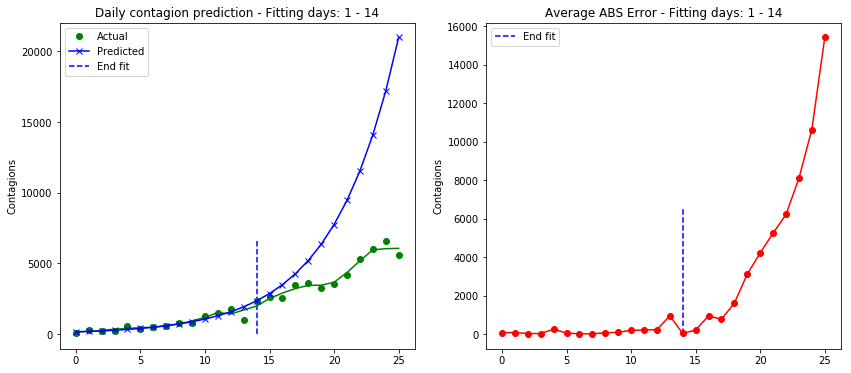


FITTING DAYS 17
------------
Errore medio GLOBALE: 703.5
Errore medio FIT: 98.2


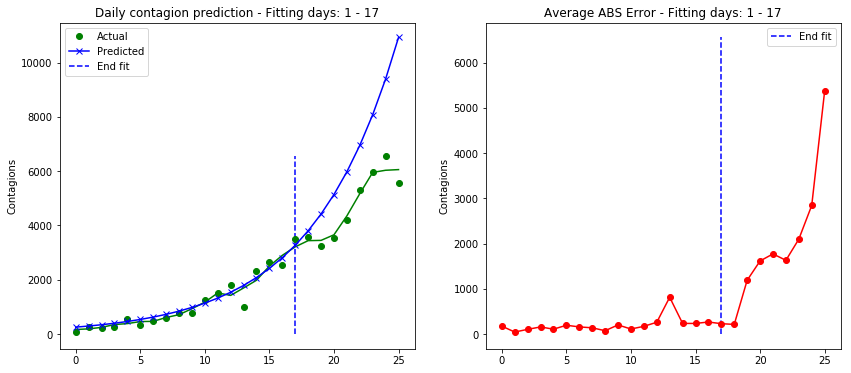


FITTING DAYS 21
------------
Errore medio GLOBALE: 359.5
Errore medio FIT: 136.6


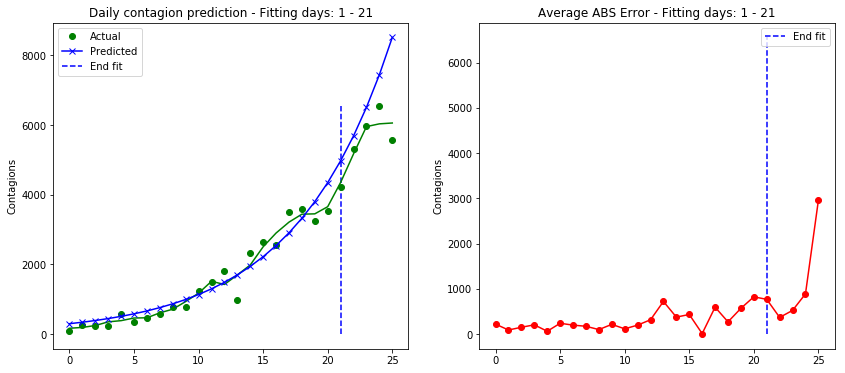


FITTING DAYS 24
------------
Errore medio GLOBALE: 427.8
Errore medio FIT: 249.6


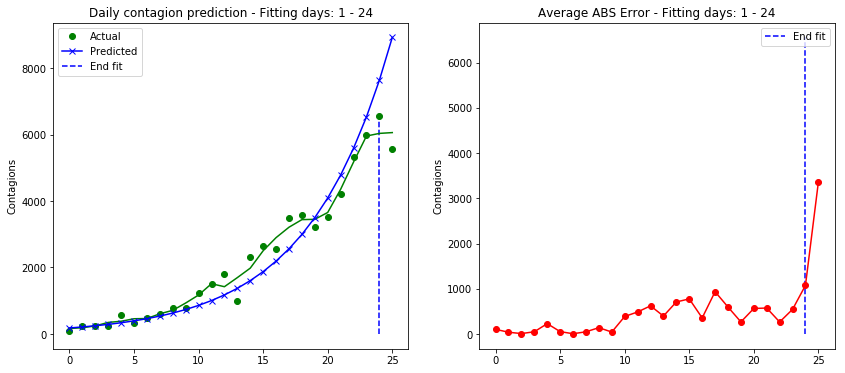

In [189]:
errors_collector=[]

for ns,solution in enumerate(solutions_collector):
    # funzione
    final_fun=fun_daily_contagions(solution[0],solution[1],solution[2],solution[3])
    # predetti
    pred_y=np.zeros_like(actual_dc)
    for i,x in enumerate(data_days):
        pred_y[i]=final_fun(x)
    
    
    global_error=np.mean(np.abs(pred_y-actual_dc_sm))
    fit_error=np.mean(np.abs(pred_y[0:fitting_days]-actual_dc_sm[0:fitting_days]))
    fitting_days=lista_fitting_days[ns]
    errors_collector.append([global_error,fit_error])
    print('\nFITTING DAYS %d'%fitting_days)
    print('------------')
    print('Errore medio GLOBALE: %4.1f'%(global_error))   
    print('Errore medio FIT: %4.1f'%(fit_error))   
    
    # predetto-misurato
    fig,ax=plt.subplots(1,2,figsize=(14,6))
    ax[0].set_title('Daily contagion prediction - Fitting days: 1 - %d'%fitting_days)
    ax[0].set_ylabel('Contagions')
    ax[0].plot(actual_dc,'go',label='Actual')
    ax[0].plot(actual_dc_sm,'g-')
    ax[0].plot(pred_y,'bx-',label='Predicted')
    ax[0].vlines(fitting_days,ymin=0,ymax=max(actual_dc),colors='b',linestyles='dashed',label='End fit')
    ax[0].legend()
        
    ax[1].set_title('Average ABS Error - Fitting days: 1 - %d'%fitting_days)
    ax[1].set_ylabel('Contagions')
    ax[1].plot(np.abs(pred_y-actual_dc),'ro-')
    ax[1].vlines(fitting_days,ymin=0,ymax=max(actual_dc),colors='b',linestyles='dashed',label='End fit')
    ax[1].legend()
    
    plt.show()
    
    '''
    # errore
    plt.figure(figsize=(10,8))
    plt.title('Error')
    plt.ylabel('Contagions')
    plt.plot(pred_y-actual_dc,'ro-')
    plt.vlines(fitting_days,ymin=0,ymax=max(actual_dc),colors='b',linestyles='dashed',label='End fit')
    plt.show()'''

### Confronto errori fra i vari modelli

In [190]:
error_data=pd.DataFrame(errors_collector,columns=['GlobErr','FitErr'],index=lista_fitting_days)
error_data

,GlobErr,FitErr
14,2225.142362,1324.257416
17,703.455718,98.167121
21,359.466515,136.623938
24,427.760643,249.623278


Text(0.5, 1.0, 'Error trend')

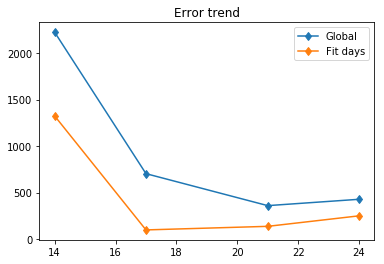

In [191]:
plt.plot(error_data,'d-')
plt.legend(['Global','Fit days'])
plt.title('Error trend')